In [1]:
pip install opencv-python torch torchvision

Note: you may need to restart the kernel to use updated packages.


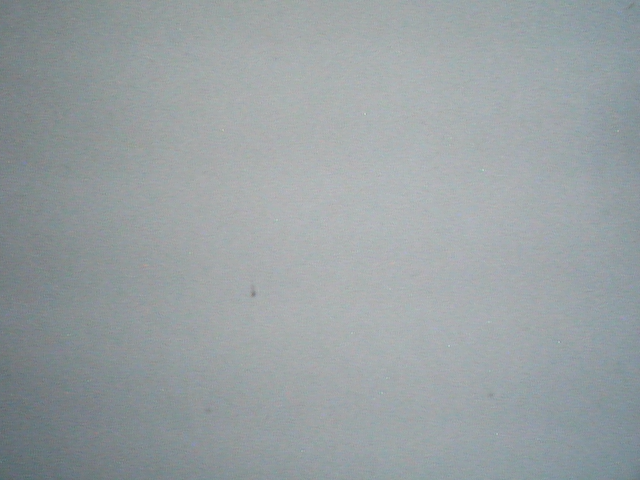

KeyboardInterrupt: 

In [5]:
import torch
import cv2
import numpy as np
import sys
import pathlib
from pathlib import Path, WindowsPath
from PIL import Image
from IPython.display import display, clear_output

# 🔧 Fix for PosixPath issue from Linux-trained models
pathlib.PosixPath = WindowsPath

# Add YOLOv5 repo path
sys.path.append('./yolov5')

# Import YOLOv5 modules
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.general import non_max_suppression, check_img_size
from yolov5.utils.torch_utils import select_device

# ✅ Custom scale_coords function
def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    if ratio_pad is None:
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])
        pad = ((img1_shape[1] - img0_shape[1] * gain) / 2,
               (img1_shape[0] - img0_shape[0] * gain) / 2)
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]
    coords[:, [1, 3]] -= pad[1]
    coords[:, :4] /= gain
    coords[:, 0].clamp_(0, img0_shape[1])
    coords[:, 1].clamp_(0, img0_shape[0])
    coords[:, 2].clamp_(0, img0_shape[1])
    coords[:, 3].clamp_(0, img0_shape[0])
    return coords

# Load model
weights_path = str(Path('yolov5/runs/train/monedas_yolov5s6/weights/best.pt').resolve())
device = select_device('0' if torch.cuda.is_available() else 'cpu')
model = DetectMultiBackend(weights_path, device=device)
stride, names = model.stride, model.names
img_size = check_img_size(640, s=stride)
model.eval()

# Initialize webcam
cap = cv2.VideoCapture(0)

# 📝 Initialize video writer to save the output
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'MJPG', 'mp4v', etc.
fps = 20.0
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output.avi', fourcc, fps, (frame_width, frame_height))

print("Recording... Press the stop button (interrupt kernel) to stop.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    img0 = frame.copy()
    img = cv2.resize(img0, (img_size, img_size))
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)

    img_tensor = torch.from_numpy(img).to(device)
    img_tensor = img_tensor.float() / 255.0
    if img_tensor.ndimension() == 3:
        img_tensor = img_tensor.unsqueeze(0)

    pred = model(img_tensor)
    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)

    for det in pred:
        if len(det):
            det[:, :4] = scale_coords(img_tensor.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in det:
                label = f'{names[int(cls)]} {conf:.2f}'
                cv2.rectangle(img0, (int(xyxy[0]), int(xyxy[1])),
                              (int(xyxy[2]), int(xyxy[3])), (255, 0, 0), 2)
                cv2.putText(img0, label, (int(xyxy[0]), int(xyxy[1]) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Write to video file
    out.write(img0)

    # Display in notebook
    img_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    display(Image.fromarray(img_rgb))

# Cleanup
cap.release()
out.release()
print("Recording saved to output.avi")
